Rayleigh-Taylor instability
===========================

Rationale
---------

One may wish to simulate a geodynamical flow involving multiple physical phases. A
possible approach is to approximate phases as immiscible and forming a single fluid
whose dynamics can still be described as a single-phase Stokes flow. Under this
approximation, it is common to refer to immiscible phases as materials and to the
resulting simulations as multi-material. In such simulations, each material occupies
part of the numerical domain and is characterised by its own physical properties,
such as density and viscosity. Along material boundaries, physical properties are
averaged according to a chosen mathematical scheme.

Numerical approach
------------------

To model the coexistence of multiple materials in the numerical domain, we employ an
interface-capturing approach called the conservative level-set method. Level-set
methods associate each material interface to a mathematical field representing a
measure of distance from that interface. In the conservative level-set approach, the
classic signed-distance function, $\phi$, employed in the level-set method is
transformed into a smooth step function, $\psi$, according to

$$\psi(\mathbf{x}, t) = \frac{1}{2} \left[
\mathrm{tanh} \left( \frac{\phi(\mathbf{x}, t)}{2\epsilon} \right) + 1
\right]$$

Throughout the simulation, the level-set field is advected with the flow:

$$\frac{\partial \psi}{\partial t} + \nabla \cdot \left( \mathbf{u}\psi \right) = 0$$

Advection of the level set modifies the shape of the initial profile. In other words,
the signed-distance property underpinning the smooth step function is lost. To
maintain the original profile as the simulation proceeds, a reinitialisation
procedure is employed. We choose the equation proposed in [Parameswaran and Mandal
(2023)](https://www.sciencedirect.com/science/article/pii/S0997754622001364):

$$\frac{\partial \psi}{\partial \tau_{n}} = \theta \left[
-\psi \left( 1 - \psi \right) \left( 1 - 2\psi \right)
+ \epsilon \left( 1 - 2\psi \right) \lvert\nabla\psi\rvert
\right]$$

This example
------------

Here, we consider the isoviscous Rayleigh-Taylor instability presented in [van Keken
et al. (1997)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/97JB01353).
Inside a 2-D domain, a buoyant, lighter material sits beneath a denser material. The
initial material interface promotes the development of a rising instability on the
domain's left-hand side, and further smaller-scale convective dynamics take place
throughout the remainder of the simulation. We describe below how to implement this
problem using G-ADOPT.

As with all examples, the first step is to import the `gadopt` package, which
provides access to Firedrake and associated functionality.

In [1]:
from gadopt import *

We next set up the mesh and function spaces and specify functions to hold our
solutions, as in our previous tutorials.

In [2]:
nx, ny = 40, 40  # Number of cells in x and y directions
lx, ly = 0.9142, 1  # Domain dimensions in x and y directions
# Rectangle mesh generated via Firedrake
mesh = RectangleMesh(nx, ny, lx, ly, quadrilateral=True)
mesh.cartesian = True
boundary = get_boundary_ids(mesh)

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Z = MixedFunctionSpace([V, W])  # Stokes function space (mixed)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
K = FunctionSpace(mesh, "DQ", 2)  # Level-set function space (scalar, discontinuous)
R = FunctionSpace(mesh, "R", 0)  # Real space for time step

z = Function(Z)  # A field over the mixed function space Z
u, p = split(z)  # Symbolic UFL expressions for velocity and pressure
z.subfunctions[0].rename("Velocity")  # Associated Firedrake velocity function
z.subfunctions[1].rename("Pressure")  # Associated Firedrake pressure function
T = Function(Q, name="Temperature")  # Firedrake function for temperature
psi = Function(K, name="Level set")  # Firedrake function for level set

We now provide initial conditions for the level-set field. To this end, we use the
`shapely` library to represent the initial location of the material interface and
derive the signed-distance function. Finally, we apply the transformation to obtain a
smooth step function profile.

In [3]:
import numpy as np  # noqa: E402
import shapely as sl  # noqa: E402


def cosine_curve(x, amplitude, wavelength, vertical_shift):
    """Cosine curve equation with an amplitude and a vertical shift"""
    return amplitude * np.cos(2 * np.pi / wavelength * x) + vertical_shift


interface_deflection = 0.02  # Amplitude of the cosine function marking the interface
interface_wavelength = 2 * lx  # Wavelength of the cosine function
material_interface_y = 0.2  # Vertical shift of the interface along the y axis
# Group parameters defining the cosine profile
isd_params = (interface_deflection, interface_wavelength, material_interface_y)

# Shapely LineString representation of the material interface
interface_x = np.linspace(0, lx, 1000)  # Enough points to capture the interface shape
interface_y = cosine_curve(interface_x, *isd_params)
line_string = sl.LineString([*np.column_stack((interface_x, interface_y))])
sl.prepare(line_string)

# Extract node coordinates
node_coords_x, node_coords_y = node_coordinates(psi)
# Determine to which material nodes belong and calculate distance to interface
node_relation_to_curve = [
    (
        node_coord_y > cosine_curve(node_coord_x, *isd_params),
        line_string.distance(sl.Point(node_coord_x, node_coord_y)),
    )
    for node_coord_x, node_coord_y in zip(node_coords_x, node_coords_y)
]

# Define the signed-distance function and overwrite its value array
signed_dist_to_interface = Function(K)
signed_dist_to_interface.dat.data[:] = [
    dist if is_above else -dist for is_above, dist in node_relation_to_curve
]

# Define thickness of the hyperbolic tangent profile
min_mesh_edge_length = min(lx / nx, ly / ny)
epsilon = Constant(min_mesh_edge_length / 4)

# Initialise level set as a smooth step function
psi.interpolate((1 + tanh(signed_dist_to_interface / 2 / epsilon)) / 2)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7c9fc1046c00>, FiniteElement('DQ', quadrilateral, 2), name=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 0)), 10)

We next define materials present in the simulation using the `Material` class. Here,
the problem is non-dimensionalised and can be described by the product of the
expressions for the Rayleigh and buoyancy numbers, RaB, which is also referred to as
compositional Rayleigh number. Therefore, we provide a value for thermal and
compositional Rayleigh numbers to define our approximation. Material fields, such as
RaB, are created using the `field_interface` function, which generates a unique field
over the numerical domain based on the level-set field(s) and values or expressions
associated with each material. At the interface between two materials, the transition
between values or expressions can be represented as sharp or diffuse, with the latter
using averaging schemes, such as arithmetic, geometric, and harmonic means.

In [4]:
buoyant_material = Material(RaB=-1)  # Vertical direction is flipped in the benchmark
dense_material = Material(RaB=0)
materials = [buoyant_material, dense_material]

Ra = 0  # Thermal Rayleigh number

RaB = field_interface(
    [psi], [material.RaB for material in materials], method="arithmetic"
)  # Compositional Rayleigh number, defined based on each material value and location

approximation = BoussinesqApproximation(Ra, RaB=RaB)

As with the previous examples, we set up an instance of the `TimestepAdaptor` class
for controlling the time-step length (via a CFL criterion) whilst the simulation
advances in time. We specify the initial time, initial time step $\Delta t$, and
output frequency (in time units).

In [5]:
time_now = 0  # Initial time
delta_t = Function(R).assign(1)  # Initial time step
output_frequency = 10  # Frequency (based on simulation time) at which to output
t_adapt = TimestepAdaptor(
    delta_t, u, V, target_cfl=0.6, maximum_timestep=output_frequency
)  # Current level-set advection requires a CFL condition that should not exceed 0.6.

This problem setup has a constant pressure nullspace, which corresponds to the
default case handled in G-ADOPT.

In [6]:
Z_nullspace = create_stokes_nullspace(Z)

/home/firedrake/firedrake/src/firedrake/firedrake/functionspaceimpl.py:160: FutureWarning: The 'subfunctions' property is deprecated for function spaces, please use the 'subspaces' property instead
  warnings.warn("The 'subfunctions' property is deprecated for function spaces, please use the "


Boundary conditions are specified next: no slip at the top and bottom and free slip
on the left and ride sides. No boundary conditions are required for level set, as the
numerical domain is closed.

In [7]:
stokes_bcs = {
    boundary.bottom: {"u": 0},
    boundary.top: {"u": 0},
    boundary.left: {"ux": 0},
    boundary.right: {"ux": 0},
}

We now set up our output. To do so, we create the output file as a ParaView Data file
that uses the XML-based VTK file format. We also open a file for logging, instantiate
G-ADOPT geodynamical diagnostic utility, and define some parameters specific to this
problem.

In [8]:
output_file = VTKFile("output.pvd")

plog = ParameterLog("params.log", mesh)
plog.log_str("step time dt u_rms entrainment")

gd = GeodynamicalDiagnostics(z, T, boundary.bottom, boundary.top)

material_area = material_interface_y * lx  # Area of tracked material in the domain
entrainment_height = 0.2  # Height above which entrainment diagnostic is calculated

Here, we set up the variational problem for the Stokes and level-set systems. The
former depends on the approximation defined above, and the latter includes both
advection and reinitialisation components. Subcycling is available for level-set
advection and is mainly useful when the problem at hand involves multiple CFL
conditions, with the CFL for level-set advection being the most restrictive.

In [9]:
stokes_solver = StokesSolver(
    z,
    T,
    approximation,
    bcs=stokes_bcs,
    nullspace=Z_nullspace,
    transpose_nullspace=Z_nullspace,
)

subcycles = 1  # Number of advection solves to perform within one time step
level_set_solver = LevelSetSolver(psi, u, delta_t, eSSPRKs10p3, subcycles, epsilon)
# Increase the reinitialisation time step to make up for the coarseness of the mesh
level_set_solver.reini_params["tstep"] *= 20

Finally, we initiate the time loop, which runs until the simulation end time is
attained.

In [10]:
step = 0  # A counter to keep track of looping
output_counter = 0  # A counter to keep track of outputting
time_end = 2000
while True:
    # Write output
    if time_now >= output_counter * output_frequency:
        output_file.write(*z.subfunctions, T, psi)
        output_counter += 1

    # Update timestep
    if time_end is not None:
        t_adapt.maximum_timestep = min(output_frequency, time_end - time_now)
    t_adapt.update_timestep()
    time_now += float(delta_t)
    step += 1

    # Solve Stokes sytem
    stokes_solver.solve()

    # Advect level set
    level_set_solver.solve(step)

    # Calculate proportion of material entrained above a given height
    buoy_entr = entrainment(psi, material_area, entrainment_height)

    # Log diagnostics
    plog.log_str(f"{step} {time_now} {float(delta_t)} {gd.u_rms()} {buoy_entr}")

    # Check if simulation has completed
    if time_now >= time_end:
        log("Reached end of simulation -- exiting time-step loop")
        break

Reached end of simulation -- exiting time-step loop


At the end of the simulation, once a steady-state has been achieved, we close our
logging file and checkpoint solution fields to disk. These can later be used to
restart the simulation, if required.

In [11]:
plog.close()

with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")
    final_checkpoint.save_function(z, name="Stokes")
    final_checkpoint.save_function(psi, name="Level set")

We can visualise the final level-set field using Firedrake's built-in plotting
functionality.

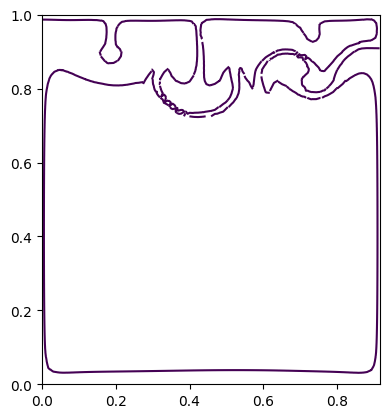

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.set_aspect("equal")
tricontour(psi, axes=axes, levels=[0.5])